In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import VarianceThreshold


%matplotlib inline

data_path = 'content'

In [20]:
df = pd.read_csv(data_path + '/data.csv')
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [35]:
target = 'Air Quality'
features = df.columns.drop(target)

dict = { key : value for value, key in enumerate(df['Air Quality'].value_counts().index)}
df[target] = df['Air Quality'].map(dict)
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,1
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,1
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,1
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,0


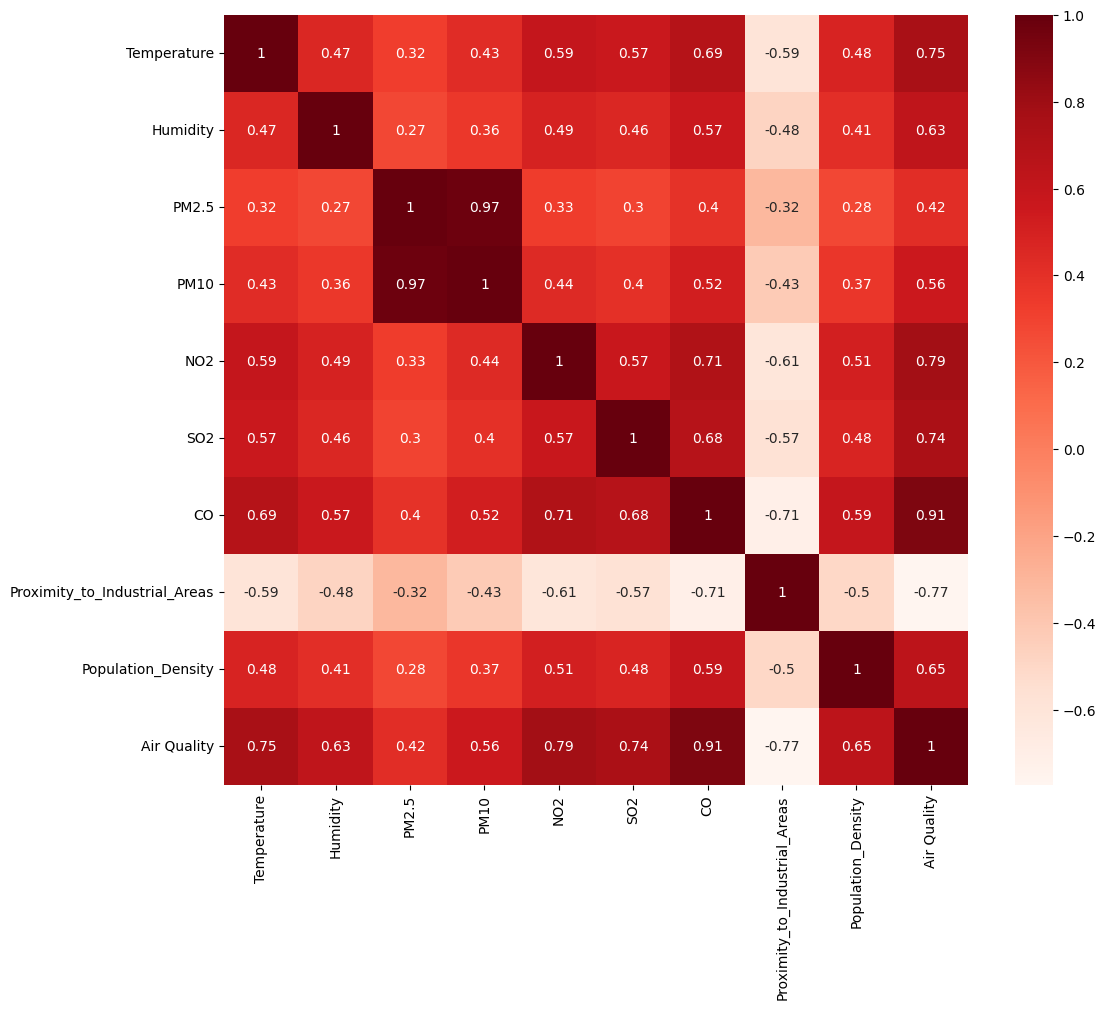

In [36]:
# feature correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [37]:
def get_top_n_features_using_importance_gain(X, Y, n=10):
  importances = mutual_info_classif(X, Y)
  feat_importances = pd.Series(importances, X.columns)
  return feat_importances.sort_values(ascending=False)[:n]

def get_top_n_features_using_chi_square(X, Y, n=10):
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    selector = SelectKBest(chi2, k=n)
    selector.fit(X_scaled, Y)

    feature_names = X.columns
    return pd.Series(selector.scores_, index=feature_names).sort_values(ascending=False)[:n]

def get_top_n_features_using_fisher_score(X, Y, n=10):
  return pd.Series(fisher_score.fisher_score(X.values, Y.values), index=X.columns).sort_values(ascending=False)[:n]

def get_top_n_features_using_correlation(X, Y, n=10):
  corr_matrix = X.corrwith(Y)
  return corr_matrix.sort_values(ascending=False)[:n]

def get_top_n_features_using_variance_threshold(X, Y, n=10):
  selector = VarianceThreshold()
  selector.fit(X, Y)
  feature_names = X.columns
  return pd.Series(selector.variances_, index=feature_names).sort_values(ascending=False)[:n]


methods_dict = {
    'importance_gain': get_top_n_features_using_importance_gain,
    'chi_square': get_top_n_features_using_chi_square,
    'fisher_score': get_top_n_features_using_fisher_score,
    'correlation': get_top_n_features_using_correlation,
    'variance_threshold': get_top_n_features_using_variance_threshold
}

def get_top_n_by_using_all_methods(X, Y, n=10):
  methods = methods_dict.values()
  results = []
  for method in methods:
    result = method(X, Y, n)
    results.append(result)
    del result

  return results


X = df[features]
Y = df[target]
top_10_voting_features = get_top_n_by_using_all_methods(X, Y, n=len(features))

In [38]:
method_names = methods_dict.keys()

top_10_df = pd.DataFrame({method: series.index for method, series in zip(method_names, top_10_voting_features)})
top_10_df.to_csv(f"{data_path}/feature_sorting_based_on_voting_importance.csv", index=False)
top_10_df

,importance_gain,chi_square,fisher_score,correlation,variance_threshold
0,CO,CO,CO,CO,Population_Density
1,Proximity_to_Industrial_Areas,Proximity_to_Industrial_Areas,Proximity_to_Industrial_Areas,NO2,PM10
2,NO2,NO2,NO2,Temperature,PM2.5
3,SO2,Population_Density,Temperature,SO2,Humidity
4,Temperature,Temperature,SO2,Population_Density,NO2
5,Population_Density,Humidity,Population_Density,Humidity,SO2
6,Humidity,SO2,Humidity,PM10,Temperature
7,PM10,PM10,PM10,PM2.5,Proximity_to_Industrial_Areas
8,PM2.5,PM2.5,PM2.5,Proximity_to_Industrial_Areas,CO


In [39]:
scores = {}
num_features = len(df)

for method in top_10_df.columns:
    for rank, feature in enumerate(top_10_df[method]):
        scores[feature] = scores.get(feature, 0) + (num_features - rank)

# Convert scores dictionary to a DataFrame for sorting
scores_df = pd.DataFrame(scores.items(), columns=['Feature', 'Score'])

# Sort by total score and get top 5 features
top_features = scores_df.sort_values(by='Score', ascending=False).head(5)

print(top_features)

                         Feature  Score
0                             CO  24992
2                            NO2  24989
5             Population_Density  24983
1  Proximity_to_Industrial_Areas  24982
4                    Temperature  24981


In [43]:
top_5_features = list(top_features.Feature)
top_5_features

['CO',
 'NO2',
 'Population_Density',
 'Proximity_to_Industrial_Areas',
 'Temperature']